In [ ]:
!pip install --upgrade jax==0.5.1 jaxlib==0.5.1
!pip install jaxkan diffrax

In [ ]:
from jaxkan.KAN import KAN
import jax
import jaxlib
import jax.numpy as jnp
import numpy as np
from flax import nnx
import optax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, PIDController
import matplotlib.pyplot as plt
import time

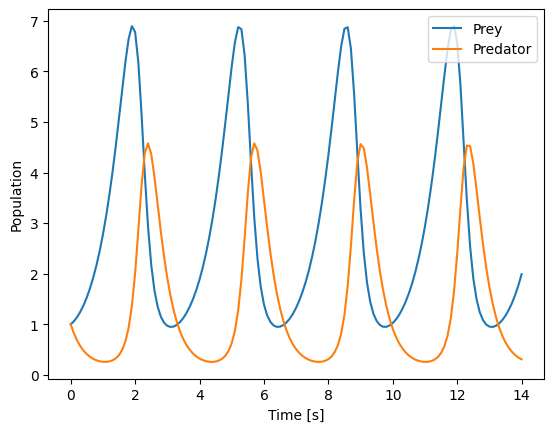

In [ ]:
# Ground Truth:

def vector_field(t, y, args):

    prey, predator = y
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = γ * prey * predator - δ * predator
    d_y = d_prey, d_predator

    return d_y

term = ODETerm(vector_field)
solver = Tsit5()
t0 = 0
t1 = 14
dt0 = 0.1
y0 = (1,1)
args = (1.5, 1, 1, 3)
stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6)
saveat = SaveAt(ts = jnp.linspace(t0, t1, 141))

sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args = args, stepsize_controller = stepsize_controller, saveat = saveat)

plt.plot(sol.ts, sol.ys[0], label = "Prey")
plt.plot(sol.ts, sol.ys[1], label = "Predator")
plt.xlabel("Time [s]")
plt.ylabel("Population")
plt.legend()
plt.show()

In [ ]:
# Dataset:

t = sol.ts
solutions = jnp.stack((sol.ys[0], sol.ys[1]), axis = 1)

t_train = t[:36]
solutions_train = solutions[:36, :]

t_test = t[36:]
solutions_test = solutions[36:, :]

window_size = 9
step_size = 3

n_train_windows = (solutions_train.shape[0] - window_size) // step_size + 1
t_train = jnp.stack([t_train[i:i+window_size] for i in range(0, n_train_windows * step_size, step_size)])
solutions_train = jnp.stack([solutions_train[i:i+window_size] for i in range(0, n_train_windows * step_size, step_size)])

n_test_windows = (solutions_test.shape[0] - window_size) // step_size + 1
t_test = jnp.stack([t_test[i:i+window_size] for i in range(0, n_test_windows * step_size, step_size)])
solutions_test = jnp.stack([solutions_test[i:i+window_size] for i in range(0, n_test_windows * step_size, step_size)])

n_windows = (solutions.shape[0] - window_size) // step_size + 1
t = jnp.stack([t[i:i+window_size] for i in range(0, n_windows * step_size, step_size)])
solutions = jnp.stack([solutions[i:i+window_size] for i in range(0, n_windows * step_size, step_size)])

train_indices = np.random.permutation(n_train_windows)
test_indices = np.random.permutation(n_test_windows)
indices = np.random.permutation(n_windows)

t_train = t_train[train_indices]
solutions_train = solutions_train[train_indices]

t_test = t_test[test_indices]
solutions_test = solutions_test[test_indices]

t = t[indices]
solutions = solutions[indices]

print(f"Train instances: {solutions_train.shape}")
print(f"Test instances: {solutions_test.shape}")

Train instances: (10, 9, 2)
Test instances: (33, 9, 2)


In [ ]:
# Models definitions:

class dF(nnx.Module):

    def __init__(self, dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        return self.dy_dt(y)

class MLP(nnx.Module):

    def __init__(self, layer_dims, rngs: nnx.Rngs):

        self.layers = [
            nnx.Linear(layer_dims[i], layer_dims[i + 1], rngs = rngs)
            for i in range(len(layer_dims) - 1)]

    def __call__(self, t,y,args):

        for layer in self.layers[:-1]:
            y = layer(y)
            y = jnp.tanh(y)

        y = self.layers[-1](y)

        return y

class NODE(nnx.Module):

    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffeqsolve(
            ODETerm(self.dF),
            Tsit5(),
            t0 = ts[0],
            t1 = ts[-1],
            dt0 = ts[1] - ts[0],
            y0 = y0,
            stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6),
            saveat = SaveAt(ts = ts),
        )
        return solution.ys[:,0,:]

In [ ]:
# Initial conditions:

y0_train = solutions_train[:, None, 0, :]
y0_test = solutions_test[:, None, 0, :]
y0 = solutions[:, None, 0, :]

# Optimizer:

opt_type = optax.adam(learning_rate = 0.001)

# Loss function:

def loss_fn(model, t, y0, solutions_true):
    solutions_pred = jax.vmap(model, in_axes=(0, 0))(t, y0)
    return jnp.mean((solutions_pred - solutions_true) ** 2)

In [ ]:
# L2 relative error:

def l2_relative_error(y_pred, y_true):
    numerator = jnp.linalg.norm(y_pred - y_true)
    denominator = jnp.linalg.norm(y_true)
    return numerator / denominator

In [ ]:
# Training step:

@nnx.jit
def train_step(model, optimizer, t_train, y0_train, solutions_train):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)

    return train_loss

# Test step:

@nnx.jit
def test_step(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)
    test_loss = loss_fn(model, t_test, y0_test, solutions_test)
    l2_error = l2_relative_error(jax.vmap(model, in_axes=(0, 0))(t, y0), solutions)

    return train_loss, test_loss, l2_error

In [ ]:
# Training function:

def train(model, optimizer, t_train, y0_train, solutions_train, num_epochs = 10000):

    train_losses = jnp.zeros(num_epochs)
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train_step(model, optimizer, t_train, y0_train, solutions_train)
        train_losses = train_losses.at[epoch].set(train_loss)

    print(f"Training time: {time.time() - start_time:.2f} seconds")

    return train_losses

# Test function:

def test(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions, num_epochs = 10000):

    train_losses = jnp.zeros(num_epochs)
    test_losses = jnp.zeros(num_epochs)
    l2_errors = jnp.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss, test_loss, l2_error = test_step(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)
        train_losses = train_losses.at[epoch].set(train_loss)
        test_losses = test_losses.at[epoch].set(test_loss)
        l2_errors = l2_errors.at[epoch].set(l2_error)

    return train_losses, test_losses, l2_errors

In [ ]:
# KAN-ODE training: (412 params)

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_KANODE = train(KANODE_model, optimizer, t_train, y0_train, solutions_train)

Training time: 220.14 seconds


In [51]:
# KAN-ODE test: (412 params)

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_KANODE, test_losses_KANODE, l2_errors_KANODE = test(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)

In [52]:
# Small-NODE training: (52 params)

MLP_model = MLP([2,10,2], nnx.Rngs(42))

NODE_small_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_small_model, opt_type)

train_losses_NODE_small = train(NODE_small_model, optimizer, t_train, y0_train, solutions_train)

Training time: 68.81 seconds


In [53]:
# Small-NODE test: (52 params)

MLP_model = MLP([2,10,2], nnx.Rngs(42))

NODE_small_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_small_model, opt_type)

train_losses_NODE_small, test_losses_NODE_small, l2_errors_NODE_small = test(NODE_small_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)

In [54]:
# Large-NODE training: (413 params)

MLP_model = MLP([2,17,18,2], nnx.Rngs(42))

NODE_large_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_large_model, opt_type)

train_losses_NODE_large = train(NODE_large_model, optimizer, t_train, y0_train, solutions_train)

Training time: 103.42 seconds


In [55]:
# Large-NODE test: (413 params)

MLP_model = MLP([2,17,18,2], nnx.Rngs(42))

NODE_large_model = NODE(MLP_model)
optimizer = nnx.Optimizer(NODE_large_model, opt_type)

train_losses_NODE_large, test_losses_NODE_large, l2_errors_NODE_large = test(NODE_large_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)

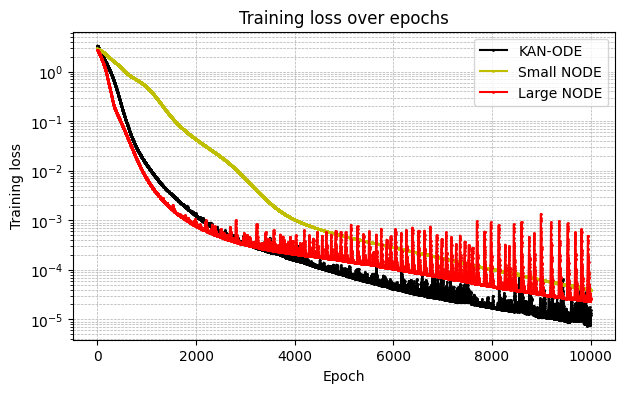

In [56]:
# Training loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(train_losses_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(train_losses_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(train_losses_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [58]:
# Final training losses:

print(f"Final training loss for the KAN-ODE : {train_losses_KANODE[-1]:.6f}")
print(f"Final training loss for the small NODE : {train_losses_NODE_small[-1]:.6f}")
print(f"Final training loss for the large NODE :  {train_losses_NODE_large[-1]:.6f}")

Final training loss for the KAN-ODE : 0.000013
Final training loss for the small NODE : 0.000039
Final training loss for the large NODE :  0.000025


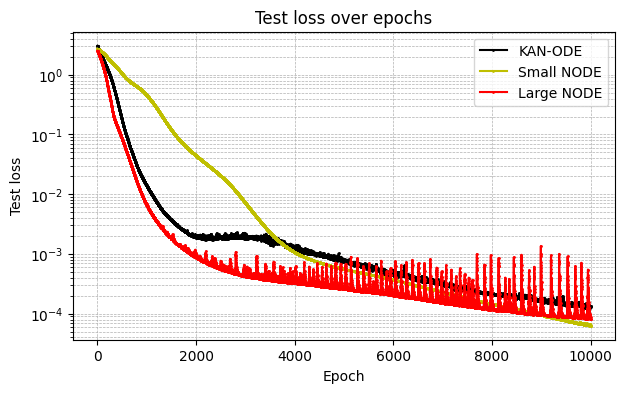

In [59]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [61]:
# Final test losses:

print(f"Final test loss for the KAN-ODE : {test_losses_KANODE[-1]:.6f}")
print(f"Final test loss for the small NODE : {test_losses_NODE_small[-1]:.6f}")
print(f"Final test loss for the large NODE :  {test_losses_NODE_large[-1]:.6f}")

Final test loss for the KAN-ODE : 0.000130
Final test loss for the small NODE : 0.000063
Final test loss for the large NODE :  0.000082


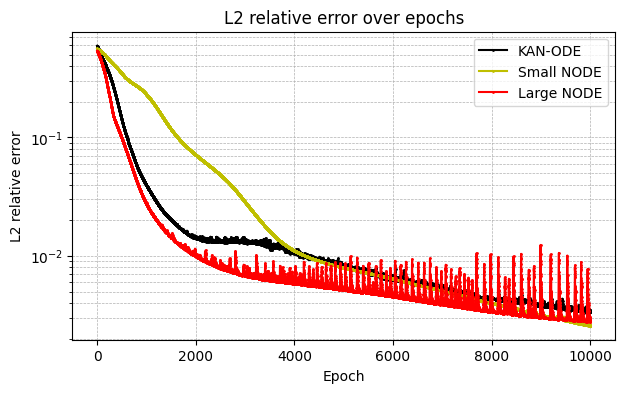

In [62]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_KANODE), label = 'KAN-ODE', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_NODE_small), label = 'Small NODE', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_NODE_large), label = 'Large NODE', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [64]:
# Final L2 relative errors:

print(f"Final L2 relative error for the KAN-ODE : {l2_errors_KANODE[-1]:.4f}")
print(f"Final L2 relative error for the small NODE : {l2_errors_NODE_small[-1]:.4f}")
print(f"Final L2 relative error for the large NODE :  {l2_errors_NODE_large[-1]:.4f}")

Final L2 relative error for the KAN-ODE : 0.0034
Final L2 relative error for the small NODE : 0.0026
Final L2 relative error for the large NODE :  0.0028


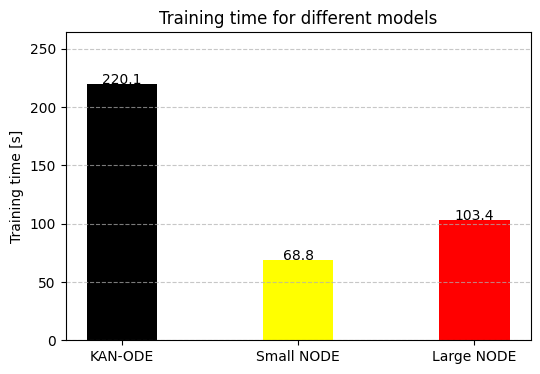

In [65]:
# Training times:

models = ["KAN-ODE", "Small NODE", "Large NODE"]
training_times = [220.14, 68.81, 103.42]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['black', 'yellow', 'red'], width = 0.4)

plt.ylabel("Training time [s]")
plt.title("Training time for different models")
plt.ylim(0, max(training_times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, time in enumerate(training_times):
    plt.text(i, time + 0.002, f"{time:.1f}", ha="center", fontsize=10)

plt.show()

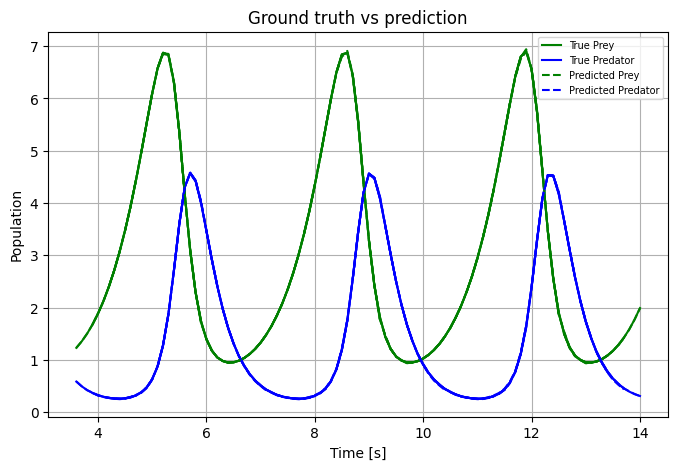

In [68]:
# Evaluation:

y_pred = jax.vmap(KANODE_model, in_axes=(0, 0))(t_test, y0_test)

ground_truth_prey = solutions_test[:, :, 0]
ground_truth_predator = solutions_test[:, :, 1]

plt.figure(figsize = (8, 5))

for i in range(ground_truth_prey.shape[0]):

    plt.plot(t_test[i], ground_truth_prey[i], label = "True Prey" if i == 0 else "", color = "g")
    plt.plot(t_test[i], ground_truth_predator[i], label = "True Predator" if i == 0 else "", color = "b")
    plt.plot(t_test[i], y_pred[i, :, 0], "--", label = "Predicted Prey" if i == 0 else "", color = "g")
    plt.plot(t_test[i], y_pred[i, :, 1], "--", label = "Predicted Predator" if i == 0 else "", color = "b")

plt.xlabel("Time [s]")
plt.ylabel("Population")
plt.title("Ground truth vs prediction")
plt.legend(fontsize = "7")
plt.grid(True)
plt.show()